# Naive Bayes Classification (from scratch)
## Toxic Comment Classification — Multi-label (Jigsaw)

**Goal**
- Train a **Multinomial Naive Bayes** model (implemented from scratch) for toxic comment classification.
- This is a **multi-label** problem: we train **one binary classifier per label**.
- Evaluate performance on the validation split using **F1**, **precision**, **recall**, and global multi-label metrics.

**Labels**
- toxic, severe_toxic, obscene, threat, insult, identity_hate


In [44]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os


from sklearn.metrics import (
    f1_score,
    precision_recall_fscore_support,
    accuracy_score,
    hamming_loss,
    roc_curve, 
    auc
)



# Make project root visible so `import src...` works
sys.path.append(os.path.abspath(".."))

from src.models.naive_bayes import fit_multilabel_nb



## 1) Load cleaned datasets

We use the cleaned Parquet files produced by the preprocessing notebook:
- `train_cleaned.parquet`
- `valid_cleaned.parquet`
- `test_cleaned.parquet`

We choose a text column (`text_aggressive` by default).


In [45]:
df_train = pd.read_parquet("../data/processed/train_cleaned.parquet")
df_test  = pd.read_parquet("../data/processed/test_cleaned.parquet")
df_valid = pd.read_parquet("../data/processed/valid_cleaned.parquet")

TEXT_COL = "text_aggressive"
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

print("Train:", df_train.shape, "Valid:", df_valid.shape, "Test:", df_test.shape)
print("Using text column:", TEXT_COL)


Train: (127656, 11) Valid: (15957, 9) Test: (15958, 9)
Using text column: text_aggressive


## 2) Train Naive Bayes (one model per label)

We train **6 independent** binary Naive Bayes models:
- `models["toxic"]` predicts the label `toxic`
- ...
- `models["identity_hate"]` predicts the label `identity_hate`

The input is a **bag-of-words** count matrix built from the cleaned text.


In [46]:
vectorizer, models, X_valid_counts = fit_multilabel_nb(
    df_train, df_valid,
    text_col=TEXT_COL,
    labels=LABELS,
    alpha=1.0
)

for label in LABELS:
    y_pred = models[label].predict(X_valid_counts)
    print(label, "F1 =", f1_score(df_valid[label], y_pred, zero_division=0))

toxic F1 = 0.7366677707850282
severe_toxic F1 = 0.42661448140900193
obscene F1 = 0.7223404255319149
threat F1 = 0.1917808219178082
insult F1 = 0.6533180778032036
identity_hate F1 = 0.3325635103926097


In [47]:
models.keys()

dict_keys(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [48]:
type(models["toxic"])


src.models.naive_bayes.MultinomialNaiveBayes

## 3) Per-label evaluation (Precision / Recall / F1)

We report:
- **pos_rate_valid**: how rare the positive class is on validation
- **precision / recall / F1** for each label


## Validation set

In [49]:
rows = []
for label in LABELS:
    y_true = df_valid[label].values
    y_pred = models[label].predict(X_valid_counts)

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    rows.append({
        "label": label,
        "pos_rate_valid": float(y_true.mean()),
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
    })

results_df = pd.DataFrame(rows).sort_values("f1", ascending=False)
results_df


,label,pos_rate_valid,precision,recall,f1
0,toxic,0.092373,0.719741,0.754410,0.736668
2,obscene,0.053331,0.659864,0.797885,0.722340
4,insult,0.048944,0.590486,0.731114,0.653318
1,severe_toxic,0.009087,0.297814,0.751724,0.426614
5,identity_hate,0.008272,0.239203,0.545455,0.332564
3,threat,0.002820,0.138614,0.311111,0.191781


## Test set

In [50]:

# Transform test set
X_test_counts = vectorizer.transform(df_test[TEXT_COL])

# Per-label evaluation for test set
rows_test = []
for label in LABELS:
    y_true = df_test[label].values
    y_pred = models[label].predict(X_test_counts)

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    rows_test.append({
        "label": label,
        "pos_rate_test": float(y_true.mean()),
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
    })

results_test_df = pd.DataFrame(rows_test).sort_values("f1", ascending=False)
display(results_test_df)

,label,pos_rate_test,precision,recall,f1
0,toxic,0.096754,0.709900,0.733808,0.721656
2,obscene,0.051698,0.632195,0.785455,0.700541
4,insult,0.049442,0.603734,0.737643,0.664005
1,severe_toxic,0.009650,0.288235,0.636364,0.396761
5,identity_hate,0.008522,0.231034,0.492647,0.314554
3,threat,0.002632,0.126582,0.238095,0.165289


## 4) Global multi-label metrics

We also compute:
- **micro-F1**: overall performance across all labels
- **macro-F1**: average across labels (treats rare labels equally)
- **exact match accuracy**: percentage of samples where all 6 labels are predicted correctly
- **hamming loss**: fraction of incorrect labels (lower is better)


## Validation set

In [51]:
Y_true = df_valid[LABELS].values

Y_pred = np.column_stack([
    models[label].predict(X_valid_counts) for label in LABELS
])

micro_f1 = f1_score(Y_true, Y_pred, average="micro", zero_division=0)
macro_f1 = f1_score(Y_true, Y_pred, average="macro", zero_division=0)
exact_acc = accuracy_score(Y_true, Y_pred)
hamm = hamming_loss(Y_true, Y_pred)

global_df = pd.DataFrame([{
    "micro_f1": micro_f1,
    "macro_f1": macro_f1,
    "exact_match_accuracy": exact_acc,
    "hamming_loss": hamm
}])

global_df


,micro_f1,macro_f1,exact_match_accuracy,hamming_loss
0,0.66098,0.510548,0.897224,0.027397


## Test set

Test Global Metrics:


,micro_f1,macro_f1,exact_match_accuracy,hamming_loss
0,0.652107,0.493801,0.892342,0.028283


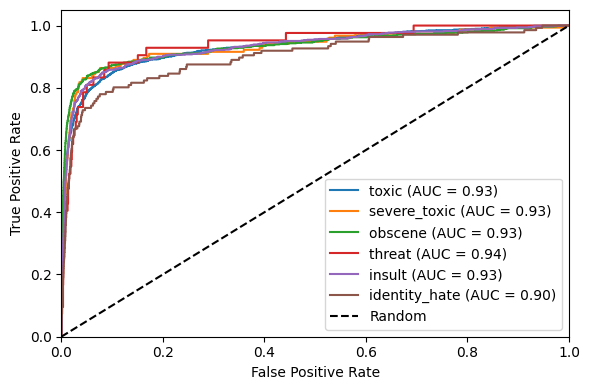

In [52]:
# Global multi-label metrics for test set
Y_true_test = df_test[LABELS].values

Y_pred_test = np.column_stack([
    models[label].predict(X_test_counts) for label in LABELS
])

micro_f1_test = f1_score(Y_true_test, Y_pred_test, average="micro", zero_division=0)
macro_f1_test = f1_score(Y_true_test, Y_pred_test, average="macro", zero_division=0)
exact_acc_test = accuracy_score(Y_true_test, Y_pred_test)
hamm_test = hamming_loss(Y_true_test, Y_pred_test)

global_test_df = pd.DataFrame([{
    "micro_f1": micro_f1_test,
    "macro_f1": macro_f1_test,
    "exact_match_accuracy": exact_acc_test,
    "hamming_loss": hamm_test
}])

print("Test Global Metrics:")
display(global_test_df)

# ROC curves for all labels
plt.figure(figsize=(6, 4))
for label in LABELS:
    y_true = df_test[label].values
    y_proba = models[label].predict_proba(X_test_counts)
    # Handle both 1D and 2D array cases
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for All Labels (Test Set)')
plt.legend(loc="lower right")
plt.tight_layout()
os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/nb_roc_curves_test.png", dpi=300, bbox_inches='tight')

plt.show()

# Overfitting check

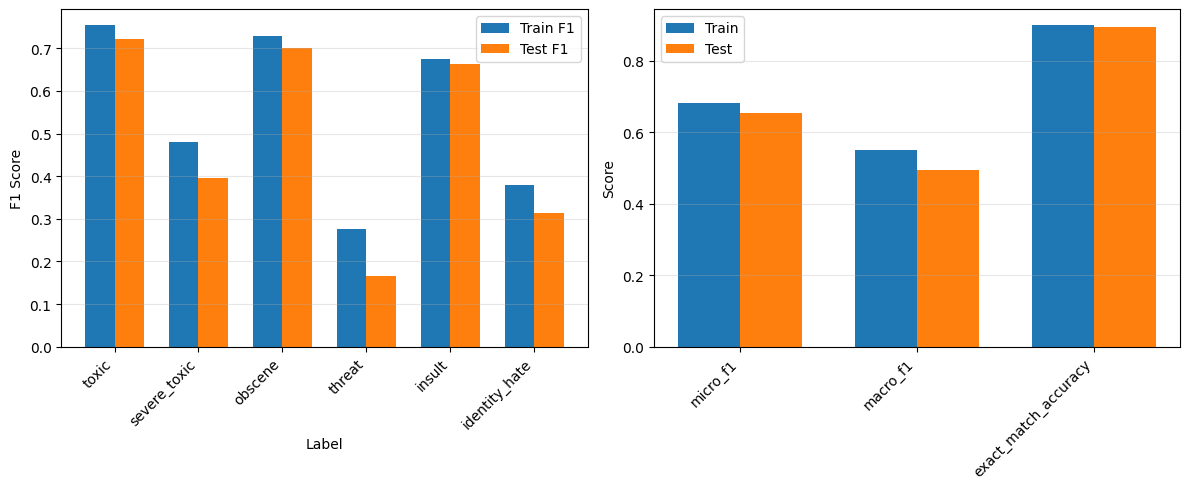

In [53]:
# Overfitting check: Compare train vs test F1 scores
# Per-label evaluation for train set
rows_train = []
X_train_counts = vectorizer.transform(df_train[TEXT_COL])
for label in LABELS:
    y_true = df_train[label].values
    y_pred = models[label].predict(X_train_counts)

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    rows_train.append({
        "label": label,
        "f1": float(f1),
    })

results_train_df = pd.DataFrame(rows_train)

# Global metrics for train set
Y_true_train = df_train[LABELS].values
Y_pred_train = np.column_stack([
    models[label].predict(X_train_counts) for label in LABELS
])

micro_f1_train = f1_score(Y_true_train, Y_pred_train, average="micro", zero_division=0)
macro_f1_train = f1_score(Y_true_train, Y_pred_train, average="macro", zero_division=0)
exact_acc_train = accuracy_score(Y_true_train, Y_pred_train)

global_train_df = pd.DataFrame([{
    "micro_f1": micro_f1_train,
    "macro_f1": macro_f1_train,
    "exact_match_accuracy": exact_acc_train,
}])

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Per-label F1 comparison
ax = axes[0]
labels_list = results_train_df["label"].values
train_f1 = results_train_df["f1"].values
test_f1 = results_test_df.set_index("label").loc[labels_list, "f1"].values

x = np.arange(len(labels_list))
width = 0.35
ax.bar(x - width/2, train_f1, width, label='Train F1')
ax.bar(x + width/2, test_f1, width, label='Test F1')
ax.set_xlabel('Label')
ax.set_ylabel('F1 Score')
# ax.set_title('Per-Label F1 Comparison (Train vs Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels_list, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Global metrics comparison
ax = axes[1]
metrics = ['micro_f1', 'macro_f1', 'exact_match_accuracy']
train_vals = [global_train_df[m].values[0] for m in metrics]
test_vals = [global_test_df[m].values[0] for m in metrics]

x = np.arange(len(metrics))
ax.bar(x - width/2, train_vals, width, label='Train')
ax.bar(x + width/2, test_vals, width, label='Test')
ax.set_ylabel('Score')
# ax.set_title('Global Metrics Comparison (Train vs Test)')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
os.makedirs("../reports/figures", exist_ok=True)

plt.savefig("../reports/figures/nb_train_vs_test_comparison.png", dpi=300, bbox_inches='tight')

plt.show()

# Save the trained model

In [54]:

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save each model as .pth file
for label in LABELS:
    model_path = f"../models/nb_{label}.pth"
    with open(model_path, "wb") as f:
        pickle.dump(models[label], f)
    print(f"Saved: {model_path}")

# Also save the vectorizer
vectorizer_path = "../models/nb_vectorizer.pth"
with open(vectorizer_path, "wb") as f:
    pickle.dump(vectorizer, f)
print(f"Saved: {vectorizer_path}")
print("\nAll models saved successfully!")

Saved: ../models/nb_toxic.pth
Saved: ../models/nb_severe_toxic.pth
Saved: ../models/nb_obscene.pth
Saved: ../models/nb_threat.pth
Saved: ../models/nb_insult.pth
Saved: ../models/nb_identity_hate.pth
Saved: ../models/nb_vectorizer.pth

All models saved successfully!
